1. **Problem Statement**

This project aims to build a machine learning model that detects fraudulent transactions using historical financial data. Fraudulent activity is rare but costly, making this a high-impact classification problem with a significant class imbalance challenge.

2. **Data Collection and Understanding**

Dataset taken from kaggle based on problem statement

**transaction_id**: A unique ID number identifying this specific purchase.

**user_id**: A unique ID number identifying the customer account making the purchase.

**account_age_days**: The number of days since this user created their account (0 = brand new).

**total_transactions_user**: The total count of past purchases this user has made before this one.

**avg_amount_user**: The average dollar amount this user typically spends per transaction.

**amount**: The actual dollar value of this current transaction.

**country**: The country code where the user is currently located or shipping the item.

**bin_country**: The country where the credit card bank is located (based on the card number).

**channel**: The platform used to make the purchase (e.g., "web" or "app").

**merchant_category**: The category of the item being purchased (e.g., "electronics", "fashion").

**promo_used**: A flag (0 or 1) indicating if a discount code or coupon was used.

**avs_match**: Address Verification System result (1 = User address matches bank records, 0 = Mismatch).

**cvv_result**: Security code check (1 = Correct CVV/CVC entered, 0 = Incorrect).

**three_ds_flag**: 3D-Secure authentication flag (1 = Extra password/OTP verification used, 0 = Not used).

**transaction_time**: The exact date and time (UTC) when the transaction took place.

**shipping_distance_km**: The physical distance (in km) between the user's location and the shipping address.

**is_fraud**: The target label (1 = Fraudulent/Stolen Card, 0 = Legitimate Purchase).

# 3. **Data Cleaning and Simple EDA**

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, precision_recall_curve
import joblib

###Loading the Dataset

In [18]:
df = pd.read_csv("/content/transactions.csv")

In [19]:
df

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,299691,6000,996,45,27.93,34.07,ES,ES,web,grocery,0,1,1,0,2024-09-29T04:40:54Z,218.55,0
299691,299692,6000,996,45,27.93,68.56,ES,ES,app,travel,0,1,1,1,2024-10-03T08:49:02Z,185.55,0
299692,299693,6000,996,45,27.93,25.02,ES,ES,app,fashion,0,1,1,1,2024-10-26T07:40:38Z,33.50,0
299693,299694,6000,996,45,27.93,23.92,ES,ES,web,gaming,0,0,0,0,2024-10-27T09:31:56Z,71.75,0


###Inspecting the dataset

In [20]:
df['merchant_category'].value_counts()

,count
merchant_category,
electronics,60220
travel,59922
grocery,59913
gaming,59839
fashion,59801


In [21]:
df.shape

(299695, 17)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   transaction_id           299695 non-null  int64  
 1   user_id                  299695 non-null  int64  
 2   account_age_days         299695 non-null  int64  
 3   total_transactions_user  299695 non-null  int64  
 4   avg_amount_user          299695 non-null  float64
 5   amount                   299695 non-null  float64
 6   country                  299695 non-null  object 
 7   bin_country              299695 non-null  object 
 8   channel                  299695 non-null  object 
 9   merchant_category        299695 non-null  object 
 10  promo_used               299695 non-null  int64  
 11  avs_match                299695 non-null  int64  
 12  cvv_result               299695 non-null  int64  
 13  three_ds_flag            299695 non-null  int64  
 14  tran

In [23]:
#Checking for the Null values
#No null values found
df.isnull().mean()

,0
transaction_id,0.0
user_id,0.0
account_age_days,0.0
total_transactions_user,0.0
avg_amount_user,0.0
amount,0.0
country,0.0
bin_country,0.0
channel,0.0
merchant_category,0.0


In [24]:
df

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299690,299691,6000,996,45,27.93,34.07,ES,ES,web,grocery,0,1,1,0,2024-09-29T04:40:54Z,218.55,0
299691,299692,6000,996,45,27.93,68.56,ES,ES,app,travel,0,1,1,1,2024-10-03T08:49:02Z,185.55,0
299692,299693,6000,996,45,27.93,25.02,ES,ES,app,fashion,0,1,1,1,2024-10-26T07:40:38Z,33.50,0
299693,299694,6000,996,45,27.93,23.92,ES,ES,web,gaming,0,0,0,0,2024-10-27T09:31:56Z,71.75,0


In [25]:
df.duplicated().sum()

np.int64(0)

In [26]:
df['country'].value_counts()

,count
country,
US,32430
GB,30602
FR,30343
NL,30220
TR,30074
PL,29965
RO,29501
DE,29060
ES,28885


In [27]:
df["bin_country"].value_counts()


,count
bin_country,
US,32295
GB,30563
FR,30261
NL,30256
TR,29972
PL,29963
RO,29532
DE,29086
ES,29058


In [28]:
df["channel"].value_counts()

,count
channel,
web,152226
app,147469


In [29]:
df["merchant_category"].value_counts()

,count
merchant_category,
electronics,60220
travel,59922
grocery,59913
gaming,59839
fashion,59801


In [30]:
df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [31]:
# There is Imbalance of categories in the Target variable
df["is_fraud"].value_counts()

,count
is_fraud,
0,293083
1,6612


<Axes: ylabel='account_age_days'>

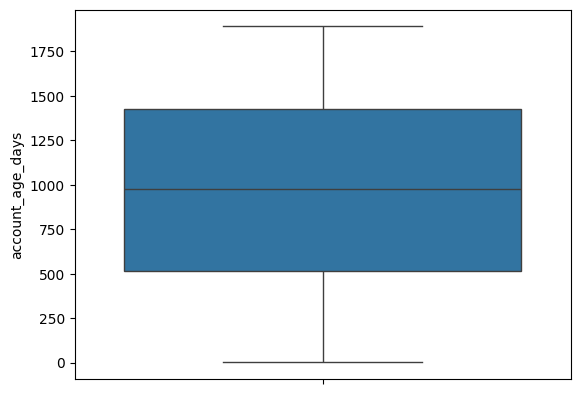

In [32]:
sns.boxplot(df["account_age_days"])

<Axes: ylabel='total_transactions_user'>

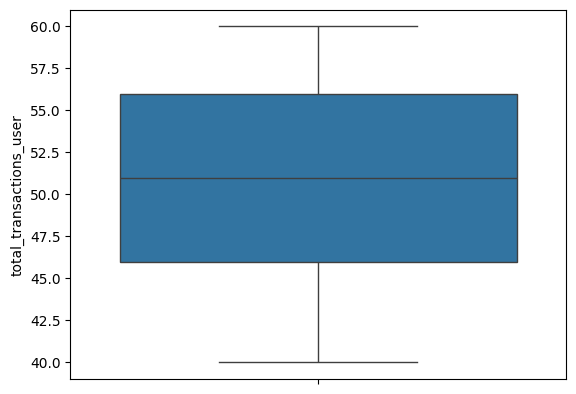

In [33]:
sns.boxplot(df["total_transactions_user"])

<Axes: ylabel='avg_amount_user'>

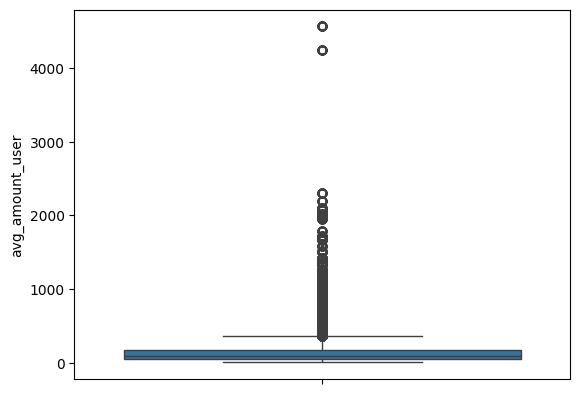

In [34]:
sns.boxplot(df["avg_amount_user"])

<Axes: ylabel='amount'>

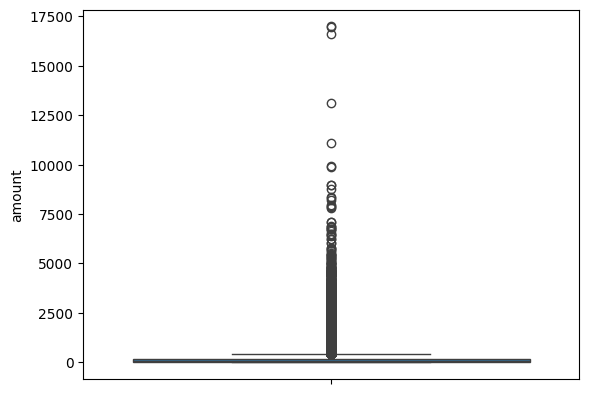

In [35]:
sns.boxplot(df["amount"])

<Axes: ylabel='shipping_distance_km'>

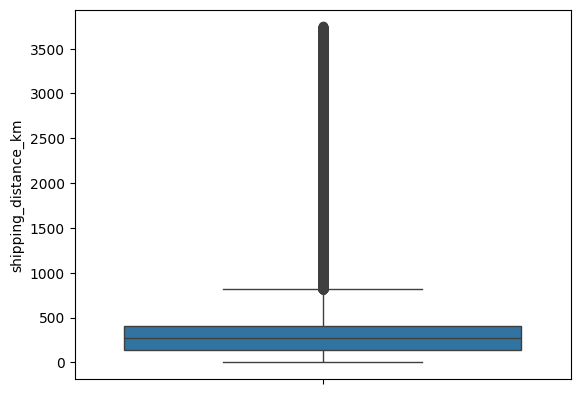

In [36]:
sns.boxplot(df["shipping_distance_km"])

## Handling Time Data

In [37]:
df['transaction_time'] = pd.to_datetime(df['transaction_time'])

In [38]:
df['hour'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.dayofweek   # 0=Monday, 6=Sunday
df['month'] = df['transaction_time'].dt.month


In [39]:
df['month'].value_counts()

,count
month,
1,30605
5,30534
8,30390
10,30361
7,30213
3,30159
9,29833
6,29691
4,29323






###Fraud vs Hour of Day

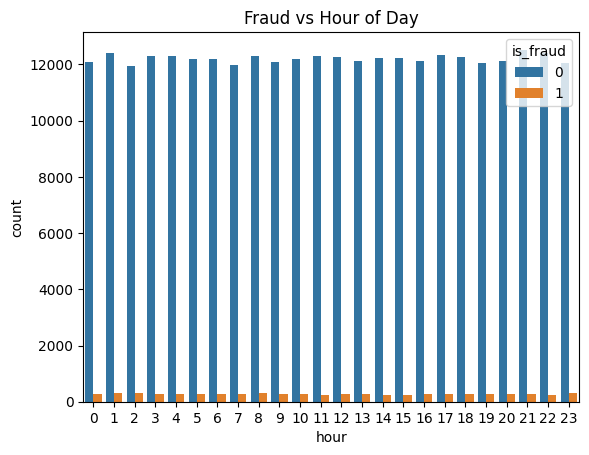

In [40]:
sns.countplot(data=df, x='hour', hue='is_fraud')
plt.title("Fraud vs Hour of Day")
plt.show()

###Fraud vs Day of Week

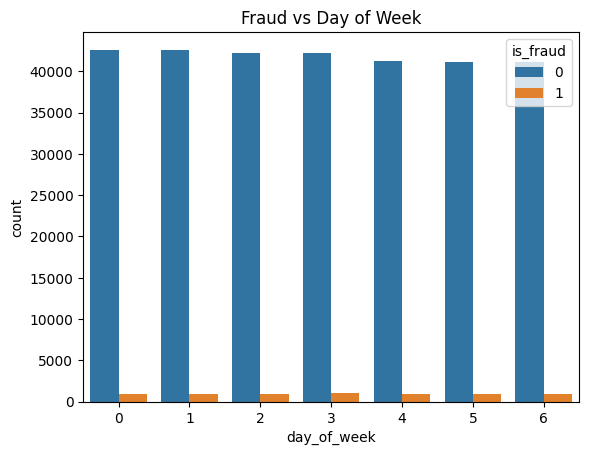

In [41]:
sns.countplot(data=df, x='day_of_week', hue='is_fraud')
plt.title("Fraud vs Day of Week")
plt.show()


###Fraud vs Month

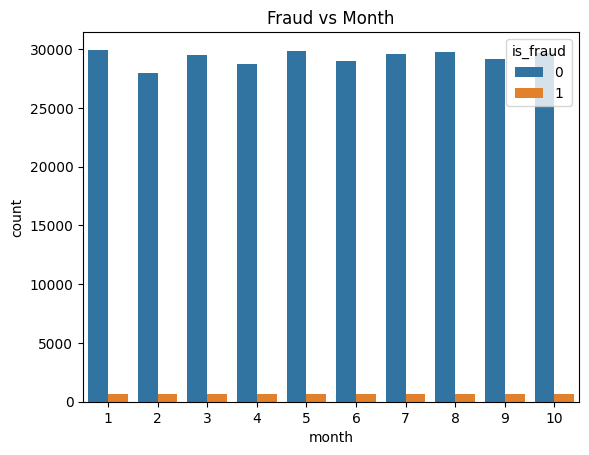

In [42]:
sns.countplot(data=df, x='month', hue='is_fraud')
plt.title("Fraud vs Month")
plt.show()


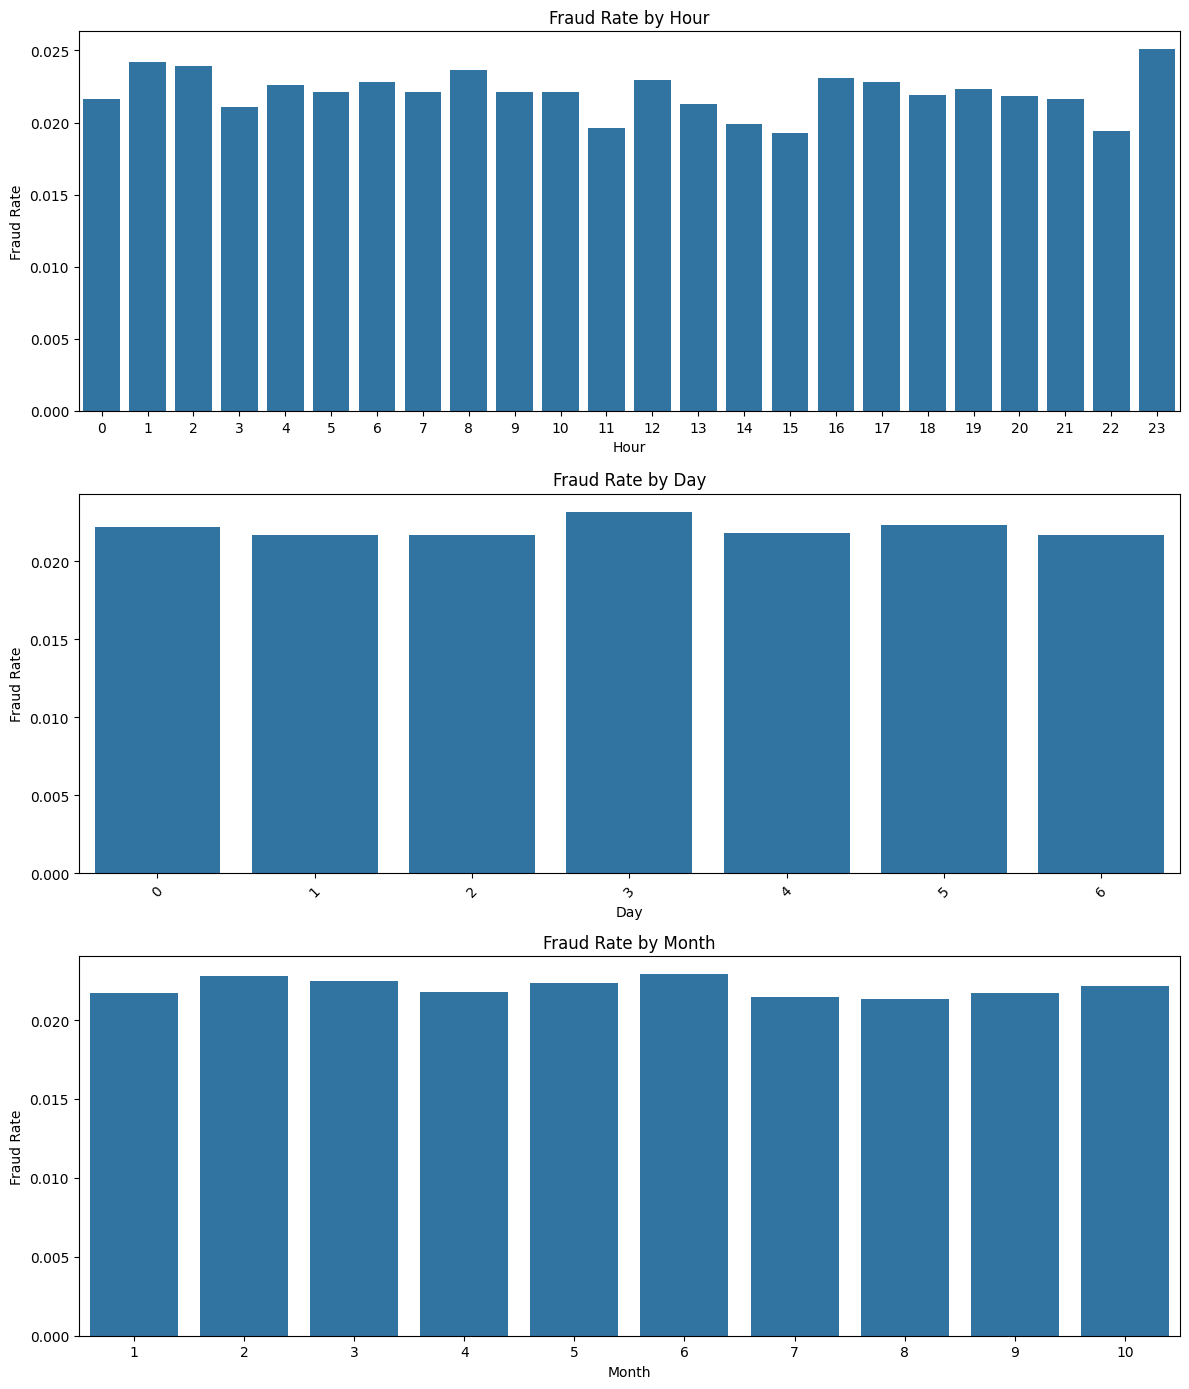

In [43]:

fig, axes = plt.subplots(3, 1, figsize=(12, 14))

# ---- Plot 1: Fraud Rate by Hour ----
hourly_fraud = df.groupby('hour')['is_fraud'].mean()
sns.barplot(x=hourly_fraud.index, y=hourly_fraud.values, ax=axes[0])
axes[0].set_title('Fraud Rate by Hour')
axes[0].set_xlabel('Hour')
axes[0].set_ylabel('Fraud Rate')

# ---- Plot 2: Fraud Rate by Day ----
daily_fraud = df.groupby('day_of_week')['is_fraud'].mean()
sns.barplot(x=daily_fraud.index, y=daily_fraud.values, ax=axes[1])
axes[1].set_title('Fraud Rate by Day')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Fraud Rate')
axes[1].tick_params(axis='x', rotation=45)

# ---- Plot 3: Fraud Rate by Month ----
monthly_fraud = df.groupby('month')['is_fraud'].mean()
sns.barplot(x=monthly_fraud.index, y=monthly_fraud.values, ax=axes[2])
axes[2].set_title('Fraud Rate by Month')
axes[2].set_xlabel('Month')
axes[2].set_ylabel('Fraud Rate')

plt.tight_layout()
plt.show()

**Observations:**

###hours vs fraud
Legitimate users typically shop during the day (9 AM to 9 PM).

Fraudsters often write scripts/bots to attack when security teams are asleep or when traffic is low (like 2 AM to 4 AM).

###day vs fraud
Uniformity: If all bars are roughly the same height, fraudsters don't care what day it is.



In [44]:
# A. Hour (Cycle = 24)
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

# B. Day of Week (Cycle = 7)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

# C. Month (Cycle = 12)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)


In [45]:
df = df.drop(columns=["hour", "day_of_week", "month"])

###justiy the droping columns

In [46]:
df = df.drop(columns=[
    "transaction_time",
    "transaction_id",
    "user_id"
])


In [47]:
df.columns

Index(['account_age_days', 'total_transactions_user', 'avg_amount_user',
       'amount', 'country', 'bin_country', 'channel', 'merchant_category',
       'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag',
       'shipping_distance_km', 'is_fraud', 'hour_sin', 'hour_cos', 'day_sin',
       'day_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [48]:
df['country_mismatch'] = df['country'] != df['bin_country']
df['country_mismatch'] = df['country_mismatch'].astype(int)

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   account_age_days         299695 non-null  int64  
 1   total_transactions_user  299695 non-null  int64  
 2   avg_amount_user          299695 non-null  float64
 3   amount                   299695 non-null  float64
 4   country                  299695 non-null  object 
 5   bin_country              299695 non-null  object 
 6   channel                  299695 non-null  object 
 7   merchant_category        299695 non-null  object 
 8   promo_used               299695 non-null  int64  
 9   avs_match                299695 non-null  int64  
 10  cvv_result               299695 non-null  int64  
 11  three_ds_flag            299695 non-null  int64  
 12  shipping_distance_km     299695 non-null  float64
 13  is_fraud                 299695 non-null  int64  
 14  hour

In [50]:
df.head()

,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,...,three_ds_flag,shipping_distance_km,is_fraud,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,country_mismatch
0,141,47,147.93,84.75,FR,FR,web,travel,0,1,...,1,370.95,0,0.866025,5.000000e-01,-0.974928,-0.222521,0.5,0.866025,0
1,141,47,147.93,107.90,FR,FR,web,travel,0,0,...,0,149.62,0,-0.866025,5.000000e-01,0.781831,0.623490,0.5,0.866025,0
2,141,47,147.93,92.36,FR,FR,app,travel,1,1,...,1,164.08,0,1.000000,6.123234e-17,-0.433884,-0.900969,0.5,0.866025,0
3,141,47,147.93,112.47,FR,FR,web,fashion,0,1,...,1,397.40,0,-0.965926,-2.588190e-01,0.000000,1.000000,0.5,0.866025,0
4,141,47,147.93,132.91,FR,US,web,electronics,0,1,...,1,935.28,0,0.258819,9.659258e-01,0.974928,-0.222521,0.5,0.866025,1


**Splitting the data**

In [51]:
X = df.drop("is_fraud", axis = 1)
y = df["is_fraud"]

In [52]:
X_train,X_test,y_train,y_test = train_test_split(X, y, stratify=y ,random_state=42)

In [53]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 224771 entries, 122552 to 11979
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   account_age_days         224771 non-null  int64  
 1   total_transactions_user  224771 non-null  int64  
 2   avg_amount_user          224771 non-null  float64
 3   amount                   224771 non-null  float64
 4   country                  224771 non-null  object 
 5   bin_country              224771 non-null  object 
 6   channel                  224771 non-null  object 
 7   merchant_category        224771 non-null  object 
 8   promo_used               224771 non-null  int64  
 9   avs_match                224771 non-null  int64  
 10  cvv_result               224771 non-null  int64  
 11  three_ds_flag            224771 non-null  int64  
 12  shipping_distance_km     224771 non-null  float64
 13  hour_sin                 224771 non-null  float64
 14  hour_

In [54]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(224771, 20)
(74924, 20)
(224771,)
(74924,)


In [55]:
df["is_fraud"].value_counts()

,count
is_fraud,
0,293083
1,6612


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299695 entries, 0 to 299694
Data columns (total 21 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   account_age_days         299695 non-null  int64  
 1   total_transactions_user  299695 non-null  int64  
 2   avg_amount_user          299695 non-null  float64
 3   amount                   299695 non-null  float64
 4   country                  299695 non-null  object 
 5   bin_country              299695 non-null  object 
 6   channel                  299695 non-null  object 
 7   merchant_category        299695 non-null  object 
 8   promo_used               299695 non-null  int64  
 9   avs_match                299695 non-null  int64  
 10  cvv_result               299695 non-null  int64  
 11  three_ds_flag            299695 non-null  int64  
 12  shipping_distance_km     299695 non-null  float64
 13  is_fraud                 299695 non-null  int64  
 14  hour

###Column groups (from your dataset)

In [57]:
encoding = [
    "country","bin_country","channel","merchant_category"
]



### Preprocessing

In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), encoding)
    ],
    remainder="passthrough"   # keep all other columns unchanged
)

# Transform X_train
X_train_transformed = preprocessor.fit_transform(X_train)

# Convert to DataFrame
X_train_df = pd.DataFrame(
    X_train_transformed,
    columns=preprocessor.get_feature_names_out(),
    index=X_train.index
)
X_test_transformed = preprocessor.transform(X_test)

# Convert to DataFrame
X_test_df = pd.DataFrame(
    X_test_transformed,
    columns=preprocessor.get_feature_names_out(),
    index=X_test.index
)

In [64]:
joblib.dump(preprocessor, "preprocessor.pkl")

['preprocessor.pkl']

### cross-validation

In [59]:
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

### --- Helper Function for Threshold Adjustment ---

In [60]:
def print_high_recall_report(model, X_test, y_test, target_recall=0.90):
    """
    Finds the threshold required to achieve a specific Recall (e.g., 90%)
    and prints the classification report for that threshold.
    """
    # Get probabilities for the positive class (Fraud)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate Precision-Recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # Find the threshold where Recall is closest to target_recall
    # We look for the first index where recall drops below target
    try:
        idx = np.where(recalls >= target_recall)[0][-1]
        custom_thresh = thresholds[idx]
    except IndexError:
        custom_thresh = 0.5 # Fallback

    print(f"\n>>> Threshold optimized for {target_recall*100}% Recall: {custom_thresh:.4f}")

    # Apply custom threshold
    y_pred_custom = (y_probs >= custom_thresh).astype(int)
    print(classification_report(y_test, y_pred_custom))

In [61]:
xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5,random_state=42)),
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,tree_method='hist'))
])

# Params must be prefixed with 'xgb__' to tell the pipeline where they go
xgb_params = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}

In [63]:
print(X_train_df.columns)

Index(['onehot__country_DE', 'onehot__country_ES', 'onehot__country_FR',
       'onehot__country_GB', 'onehot__country_IT', 'onehot__country_NL',
       'onehot__country_PL', 'onehot__country_RO', 'onehot__country_TR',
       'onehot__country_US', 'onehot__bin_country_DE',
       'onehot__bin_country_ES', 'onehot__bin_country_FR',
       'onehot__bin_country_GB', 'onehot__bin_country_IT',
       'onehot__bin_country_NL', 'onehot__bin_country_PL',
       'onehot__bin_country_RO', 'onehot__bin_country_TR',
       'onehot__bin_country_US', 'onehot__channel_app', 'onehot__channel_web',
       'onehot__merchant_category_electronics',
       'onehot__merchant_category_fashion', 'onehot__merchant_category_gaming',
       'onehot__merchant_category_grocery', 'onehot__merchant_category_travel',
       'remainder__account_age_days', 'remainder__total_transactions_user',
       'remainder__avg_amount_user', 'remainder__amount',
       'remainder__promo_used', 'remainder__avs_match',
       'remai

In [ ]:
with open("onehot.pkl","wb") as f:
  joblib.dump(,f)

## Model Fit (Training with Tuning)

In [62]:
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=5,
    scoring='average_precision', # PR-AUC
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_df, y_train)

print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"Best PR-AUC Score: {xgb_search.best_score_:.4f}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits


KeyboardInterrupt: 

In [ ]:
   # This uses the BEST model automatically
xgb_pred = xgb_search.predict(X_test_df)

In [ ]:
print("classification_matrix\n:",classification_report(y_test, xgb_pred))

In [ ]:
print_high_recall_report(xgb_search, X_test_df, y_test, target_recall=0.90)

In [ ]:
'''# --- 3. Random Forest Tuning with SMOTE ---
print("\n--- Tuning Random Forest (with SMOTE) ---")

rf_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5,random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
'''

In [ ]:
''''# Params must be prefixed with 'rf__'
rf_params = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [10, 20, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
    # Removed class_weight
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_params,
    n_iter=10,
    scoring='average_precision',
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)

print(f"Best Random Forest Params: {rf_search.best_params_}")
print(f"Best PR-AUC Score: {rf_search.best_score_:.4f}")'''

In [ ]:
'''rf_pred = rf_search.predict(X_test_processed)'''

In [ ]:
'''print("classification_matrix\n:",classification_report(y_test, rf_pred))'''

In [ ]:
'''print_high_recall_report(rf_search, X_test_processed, y_test, target_recall=0.90)'''

In [ ]:
import pickle

# 1. Define your custom threshold (from your screenshot output)
optimal_threshold = 0.0280

# 2. Create a dictionary to bundle the model and the threshold
model_data = {
    "model": xgb_search,         # The trained model object
    "threshold": optimal_threshold # The threshold for 90% recall
}

# 3. Save the bundle to a pickle file
filename = 'xgb_fraud_model_with_threshold.pkl'
pickle.dump(model_data, open(filename, 'wb'))

print(f"Model and threshold saved as {filename}")

In [ ]:
pip freeze > requirements.txt


In [ ]:
from google.colab import files
files.download("requirements.txt")


FileNotFoundError: Cannot find file: requirements.txt

In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.2 MB/s eta 0:00:00


In [ ]:
import streamlit as st

In [ ]:
dir(st)

['Page',
 '_ContextProxy',
 '_DeltaGenerator',
 '_DeltaGeneratorSingleton',
 '_DeprecatedUserInfoProxy',
 '_Dialog',
 '_EXPERIMENTAL_QUERY_PARAMS_DEPRECATE_MSG',
 '_QueryParamsProxy',
 '_STREAMLIT_VERSION_STRING',
 '_SessionStateProxy',
 '_StatusContainer',
 '_UserInfoProxy',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_bidi_component',
 '_bottom',
 '_cache',
 '_cache_data',
 '_cache_resource',
 '_column_config',
 '_config',
 '_connection',
 '_deprecate_func_name',
 '_dg_singleton',
 '_dialog_decorator',
 '_event',
 '_fragment',
 '_gather_metrics',
 '_get_query_params',
 '_logger',
 '_login',
 '_logout',
 '_main',
 '_os',
 '_secrets_singleton',
 '_set_query_params',
 '_update_logger',
 'altair_chart',
 'area_chart',
 'audio',
 'audio_input',
 'auth_util',
 'badge',
 'balloons',
 'bar_chart',
 'bokeh_chart',
 'button',
 'cache',
 'cache_data',
 'cache_resource',
 'camera_input',
 'captio

In [ ]:
help(st.datetime_input)

Help on method datetime_input in module streamlit.delta_generator:

datetime_input(label: 'str', value: 'DateTimeValue' = 'now', min_value: 'DateTimeValue' = None, max_value: 'DateTimeValue' = None, *, key: 'Key | None' = None, help: 'str | None' = None, on_change: 'WidgetCallback | None' = None, args: 'WidgetArgs | None' = None, kwargs: 'WidgetKwargs | None' = None, format: 'str' = 'YYYY/MM/DD', step: 'int | timedelta' = datetime.timedelta(seconds=900), disabled: 'bool' = False, label_visibility: 'LabelVisibility' = 'visible', width: 'WidthWithoutContent' = 'stretch') -> 'datetime | None' method of streamlit.delta_generator.DeltaGenerator instance
    Display a date and time input widget.

    Parameters
    ----------
    label : str
        A short label explaining to the user what this datetime input is for.
        The label can optionally contain GitHub-flavored Markdown of the
        following types: Bold, Italics, Strikethroughs, Inline Code, Links,
        and Images. Images 

In [ ]:
# cross-validation
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# --- Helper Function for Threshold Adjustment ---
def print_high_recall_report(model, X_test, y_test, target_recall=0.90):
    """
    Finds the threshold required to achieve a specific Recall (e.g., 90%)
    and prints the classification report for that threshold.
    """
    # Get probabilities for the positive class (Fraud)
    y_probs = model.predict_proba(X_test)[:, 1]

    # Calculate Precision-Recall pairs for different thresholds
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

    # Find the threshold where Recall is closest to target_recall
    # We look for the first index where recall drops below target
    try:
        idx = np.where(recalls >= target_recall)[0][-1]
        custom_thresh = thresholds[idx]
    except IndexError:
        custom_thresh = 0.5 # Fallback

    print(f"\n>>> Threshold optimized for {target_recall*100}% Recall: {custom_thresh:.4f}")

    # Apply custom threshold
    y_pred_custom = (y_probs >= custom_thresh).astype(int)
    print(classification_report(y_test, y_pred_custom))

    xgb_pipeline = ImbPipeline([
    ('smote', SMOTE(sampling_strategy=0.5,random_state=42)),
    ('xgb', XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False,tree_method='hist'))
])

# Params must be prefixed with 'xgb__' to tell the pipeline where they go
xgb_params = {
    'xgb__n_estimators': [100, 200, 300],
    'xgb__learning_rate': [0.01, 0.05, 0.1],
    'xgb__max_depth': [3, 5, 7],
    'xgb__subsample': [0.7, 0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8, 1.0]
}

# Model Fit (Training with Tuning)
xgb_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_params,
    n_iter=5,
    scoring='average_precision', # PR-AUC
    cv=cv_strategy,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

xgb_search.fit(X_train_df, y_train)

print(f"Best XGBoost Params: {xgb_search.best_params_}")
print(f"Best PR-AUC Score: {xgb_search.best_score_:.4f}")

xgb_pred = xgb_search.predict(dataframe)
if xgb_pred:
        st.write(f"prediction:{xgb_pred}")
#print("classification_matrix\n:",classification_report(y_test, xgb_pred))

#print_high_recall_report(xgb_search, X_test_df, y_test, target_recall=0.90)
